In [1]:
!pip install scikit-plot


You should consider upgrading via the '/home/ccs/Notebooks/my_env/bin/python3.6 -m pip install --upgrade pip' command.


In [2]:
import sys
!{sys.executable} -m pip install xgboost

You should consider upgrading via the '/home/ccs/Notebooks/my_env/bin/python3.6 -m pip install --upgrade pip' command.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier as xgb
import warnings

In [4]:
%matplotlib inline
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")
plt.rc("font", family="serif", size=15)

In [5]:
PdM_errors_url="https://raw.githubusercontent.com/soumya-soman/predictive-maintenance/master/PdM_errors.csv"
 
errors = pd.read_csv(PdM_errors_url)
errors.head(5)


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [6]:
maint_url="https://raw.githubusercontent.com/soumya-soman/predictive-maintenance/master/PdM_maint.csv"
 
maint = pd.read_csv(maint_url)
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [7]:
failures_url="https://raw.githubusercontent.com/soumya-soman/predictive-maintenance/master/PdM_failures.csv"
 
failures = pd.read_csv(failures_url)
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [8]:
machines_url="https://raw.githubusercontent.com/soumya-soman/predictive-maintenance/master/PdM_machines.csv"
 
machines = pd.read_csv(machines_url)
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [9]:
machines['model'].value_counts()

model3    35
model4    32
model2    17
model1    16
Name: model, dtype: int64

In [10]:
telemetry_url="https://raw.githubusercontent.com/soumya-soman/predictive-maintenance/master/PdM_telemetry.csv"
 
telemetry = pd.read_csv(telemetry_url)
telemetry.tail()

,datetime,machineID,volt,rotate,pressure,vibration
968584,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
968585,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
968586,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
968587,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259
968588,2016-01-01 06:00:00,100,171.336037,496.096870,79.095538,37.845245


In [11]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [12]:
telemetry.drop_duplicates(keep='first',inplace=True)

In [13]:
telemetry.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876101 entries, 0 to 968588
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876101 non-null  object 
 1   machineID  876101 non-null  int64  
 2   volt       876101 non-null  float64
 3   rotate     876101 non-null  float64
 4   pressure   876100 non-null  float64
 5   vibration  876100 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 46.8+ MB


In [14]:
telemetry.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

In [15]:
telemetry["machineID"].nunique()

100

In [16]:
telemetry["datetime"] = pd.to_datetime(telemetry["datetime"], format="%Y-%m-%d %H:%M:%S")
telemetry.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object

In [17]:
telemetry['year'] = telemetry['datetime'].dt.year
telemetry['month'] = telemetry['datetime'].dt.month
telemetry['day'] = telemetry['datetime'].dt.day
telemetry

,datetime,machineID,volt,rotate,pressure,vibration,year,month,day
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2015,1,1
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,2015,1,1
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,2015,1,1
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,2015,1,1
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,2015,1,1
...,...,...,...,...,...,...,...,...,...
968584,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,2016,1,1
968585,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,2016,1,1
968586,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,2016,1,1
968587,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,2016,1,1


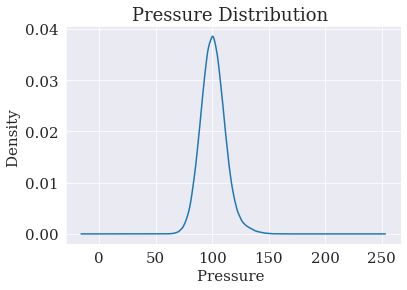

In [18]:
telemetry["pressure"].plot(kind="kde")
plt.title("Pressure Distribution ")
plt.ylabel("Density ")
plt.xlabel("Pressure ")
plt.show()

In [19]:
telemetry.describe() 

,machineID,volt,rotate,pressure,vibration,year,month,day
count,876101.000000,876101.000000,876101.000000,876100.000000,876100.000000,876101.000000,876101.000000,876101.000000
mean,50.499955,170.777762,446.605132,100.858668,40.385007,2015.000799,6.525397,15.718876
std,28.866101,15.509124,52.673857,11.048679,5.370361,0.028255,3.448160,8.797154
min,1.000000,97.333604,138.432075,51.237106,14.877054,2015.000000,1.000000,1.000000
25%,25.000000,160.304961,412.305749,93.498181,36.777299,2015.000000,4.000000,8.000000
50%,50.000000,170.607343,447.558205,100.425559,40.237247,2015.000000,7.000000,16.000000
75%,75.000000,181.004499,482.176586,107.555231,43.784938,2015.000000,10.000000,23.000000
max,100.000000,255.124717,695.020984,185.951998,76.791072,2016.000000,12.000000,31.000000


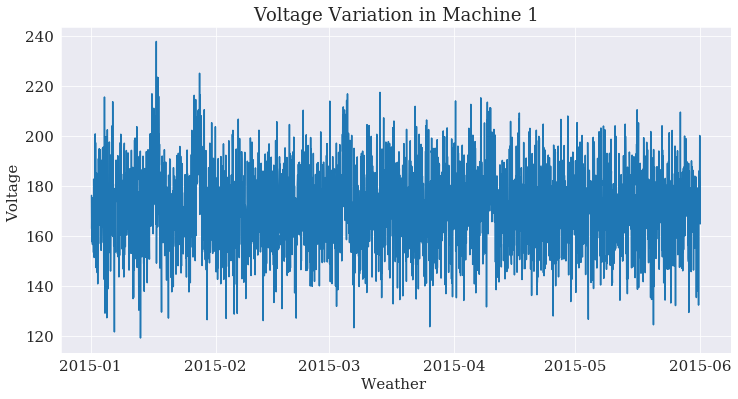

In [20]:
# We show an example graph of the voltage values ​​for machine 1 during the first 6 months of 2015.

plot_df = telemetry.loc[
    (telemetry["machineID"] == 1)
    & (telemetry["datetime"] > pd.to_datetime("2015-01-01"))
    & (telemetry["datetime"] < pd.to_datetime("2015-06-01")), ["datetime", "volt"]
]

plt.figure(figsize=(12, 6))
plt.plot(plot_df["datetime"], plot_df["volt"])
plt.title("Voltage Variation in Machine 1")
plt.ylabel("Voltage ")

# We make labels legible.
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = "%m-%d"
plt.xlabel("Weather ")
plt.show()

In [21]:
##ERROR DATA ANALYSIS
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [22]:
errors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3919 non-null   object
 1   machineID  3919 non-null   int64 
 2   errorID    3919 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.0+ KB


In [23]:
# Formatting the date and time field that comes as a string.
# Categories allow comparison between values, automatic ordering, easier graphing and other functions.
# Also less memory (similar to "factor" in R).
errors["datetime"] = pd.to_datetime(errors["datetime"], format="%Y-%m-%d %H:%M:%S")
errors["errorID"] = errors["errorID"].astype("category")
errors['year'] = errors['datetime'].dt.year
errors['month'] = errors['datetime'].dt.month
errors['day'] = errors['datetime'].dt.day

errors.head()

,datetime,machineID,errorID,year,month,day
0,2015-01-03 07:00:00,1,error1,2015,1,3
1,2015-01-03 20:00:00,1,error3,2015,1,3
2,2015-01-04 06:00:00,1,error5,2015,1,4
3,2015-01-10 15:00:00,1,error4,2015,1,10
4,2015-01-22 10:00:00,1,error4,2015,1,22


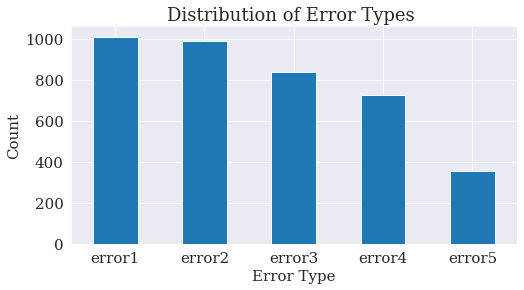

In [24]:
#sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
errors["errorID"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribution of Error Types ")
plt.ylabel("Count")
plt.xlabel("Error Type")
plt.show()

In [25]:
## MAINT DATA ANALYSIS
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [26]:
maint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3286 non-null   object
 1   machineID  3286 non-null   int64 
 2   comp       3286 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.1+ KB


In [27]:
# Formatting the date and time field that comes as a string.
maint["datetime"] = pd.to_datetime(maint["datetime"], format="%Y-%m-%d %H:%M:%S")
maint['year'] = maint['datetime'].dt.year
maint['month'] = maint['datetime'].dt.month
maint['day'] = maint['datetime'].dt.day
maint["comp"] = maint["comp"].astype("category")
maint.dtypes

datetime     datetime64[ns]
machineID             int64
comp               category
year                  int64
month                 int64
day                   int64
dtype: object

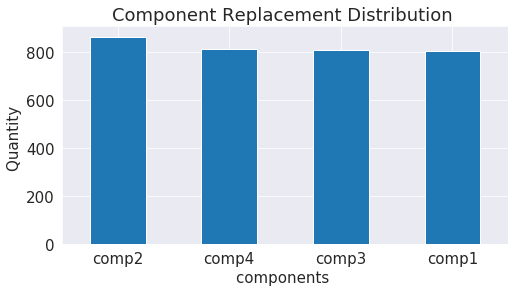

In [28]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
maint["comp"].value_counts().plot(kind="bar", rot=0)
plt.title("Component Replacement Distribution ")
plt.ylabel("Quantity ")
plt.xlabel("components ")
plt.show()

In [29]:
##Machines data analysis
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [30]:
machines.shape
machines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   machineID  100 non-null    int64 
 1   model      100 non-null    object
 2   age        100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


In [31]:
machines.dtypes

machineID     int64
model        object
age           int64
dtype: object

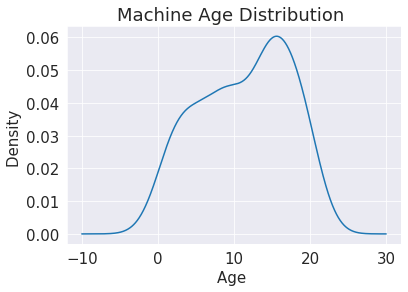

In [32]:
# We check if there are several hills as it can suggest two different groups.
machines["age"].plot(kind="kde")
plt.title("Machine Age Distribution ")
plt.xlabel("Age ")
plt.ylabel("Density ")
plt.show()

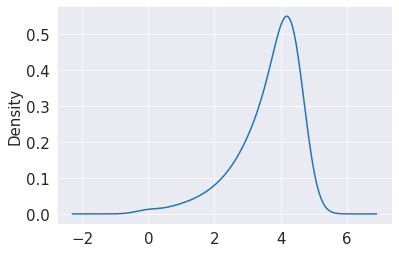

In [33]:
# We apply natural logarithm to normalize.
np.log(machines[machines["age"] != 0].iloc[:, 0]).plot(kind="kde")
plt.show()

In [34]:
machines["model"] = machines["model"].astype("category")
machines.dtypes

machineID       int64
model        category
age             int64
dtype: object

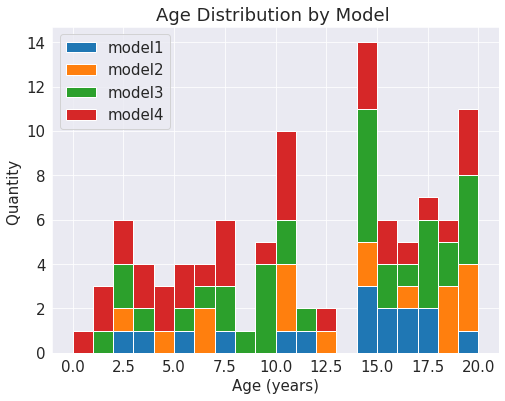

In [35]:
plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist([
    machines.loc[machines["model"] == "model1", "age"],
    machines.loc[machines["model"] == "model2", "age"],
    machines.loc[machines["model"] == "model3", "age"],
    machines.loc[machines["model"] == "model4", "age"]],
    20, stacked=True, label=["model1", "model2", "model3", "model4"
])
plt.title("Age Distribution by Model ")
plt.xlabel("Age (years)")
plt.ylabel("Quantity ")
plt.legend()
plt.show()

In [36]:
## Failures data analysis
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [37]:
failures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   761 non-null    object
 1   machineID  761 non-null    int64 
 2   failure    761 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.0+ KB


In [38]:
# We format the datetime that comes as a string
failures["datetime"] = pd.to_datetime(failures["datetime"], format="%Y-%m-%d %H:%M:%S")
failures['year'] = failures['datetime'].dt.year
failures['month'] = failures['datetime'].dt.month
failures['day'] = failures['datetime'].dt.day
failures["failure"] = failures["failure"].astype("category")
failures.dtypes

datetime     datetime64[ns]
machineID             int64
failure            category
year                  int64
month                 int64
day                   int64
dtype: object

In [39]:
failures.describe(include="all")

,datetime,machineID,failure,year,month,day
count,761,761.000000,761,761.0,761.000000,761.000000
unique,302,NaN,4,NaN,NaN,NaN
top,2015-01-02 03:00:00,NaN,comp2,NaN,NaN,NaN
freq,18,NaN,259,NaN,NaN,NaN
first,2015-01-02 03:00:00,NaN,NaN,NaN,NaN,NaN
last,2015-12-31 06:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,51.911958,NaN,2015.0,6.289093,15.170828
std,NaN,29.515542,NaN,0.0,3.521812,9.266365
min,NaN,1.000000,NaN,2015.0,1.000000,1.000000
25%,NaN,24.000000,NaN,2015.0,3.000000,6.000000


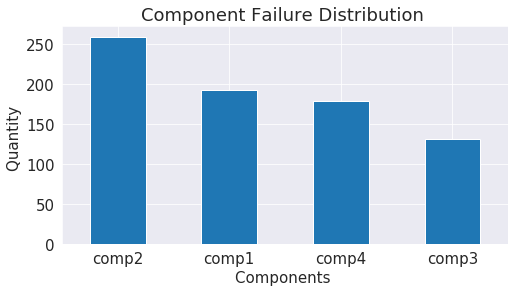

In [40]:
plt.figure(figsize=(8, 4))
failures["failure"].value_counts().plot(kind="bar", rot=0)
plt.title("Component Failure Distribution ")
plt.ylabel("Quantity ")
plt.xlabel("Components ")
plt.show()

In [41]:
# We calculate average values ​​for telemetry characteristics
# we pivot because we need the datetime as an index for "resample" to work
# resample creates the lagging
# closed = 'right' => (6:00, 9:00] or 6:00 < x <= 9:00
# closed='left'  => [6:00, 9:00) or 6:00 <= x < 9:00
# it can't be both
# unstack: return df to original format
# we have 100 machines, 4 sensors = 400 columns
# unstack shows a dataseries in the columns as an index and returns series (if there are several indexes they are rearranged).
# Each dataframe in temp has the values ​​of the field that corresponds to it at that moment.

temp = []
fields = ["volt", "rotate", "pressure", "vibration"]
temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).resample("3H", closed="left", label="right").mean().unstack()
    for col in fields
]
temp[1].head()

machineID  datetime           
1          2015-01-01 09:00:00    449.533798
           2015-01-01 12:00:00    403.949857
           2015-01-01 15:00:00    435.781707
           2015-01-01 18:00:00    430.472823
           2015-01-01 21:00:00    437.111120
dtype: float64

In [42]:
telemetry

,datetime,machineID,volt,rotate,pressure,vibration,year,month,day
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2015,1,1
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,2015,1,1
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,2015,1,1
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,2015,1,1
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,2015,1,1
...,...,...,...,...,...,...,...,...,...
968584,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,2016,1,1
968585,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,2016,1,1
968586,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,2016,1,1
968587,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,2016,1,1


In [43]:
temp

[machineID  datetime           
 1          2015-01-01 09:00:00    170.028993
            2015-01-01 12:00:00    164.192565
            2015-01-01 15:00:00    168.134445
            2015-01-01 18:00:00    165.514453
            2015-01-01 21:00:00    168.809347
                                      ...    
 100        2015-12-31 21:00:00    166.078945
            2016-01-01 00:00:00    158.327984
            2016-01-01 03:00:00    170.306956
            2016-01-01 06:00:00    182.525427
            2016-01-01 09:00:00    171.336037
 Length: 292100, dtype: float64,
 machineID  datetime           
 1          2015-01-01 09:00:00    449.533798
            2015-01-01 12:00:00    403.949857
            2015-01-01 15:00:00    435.781707
            2015-01-01 18:00:00    430.472823
            2015-01-01 21:00:00    437.111120
                                      ...    
 100        2015-12-31 21:00:00    424.431184
            2016-01-01 00:00:00    504.056262
            2016-01-01 03:00:

In [44]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration,year,month,day
count,876101.000000,876101.000000,876101.000000,876100.000000,876100.000000,876101.000000,876101.000000,876101.000000
mean,50.499955,170.777762,446.605132,100.858668,40.385007,2015.000799,6.525397,15.718876
std,28.866101,15.509124,52.673857,11.048679,5.370361,0.028255,3.448160,8.797154
min,1.000000,97.333604,138.432075,51.237106,14.877054,2015.000000,1.000000,1.000000
25%,25.000000,160.304961,412.305749,93.498181,36.777299,2015.000000,4.000000,8.000000
50%,50.000000,170.607343,447.558205,100.425559,40.237247,2015.000000,7.000000,16.000000
75%,75.000000,181.004499,482.176586,107.555231,43.784938,2015.000000,10.000000,23.000000
max,100.000000,255.124717,695.020984,185.951998,76.791072,2016.000000,12.000000,31.000000


In [45]:
telemetry_mean_3h = pd.concat(temp, axis=1) # We unite the series.
telemetry_mean_3h.columns = [col + "mean_3h" for col in fields] # We assign column names.
telemetry_mean_3h.reset_index(inplace=True) # We flatten the frame.
telemetry_mean_3h.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542


In [46]:
telemetry_mean_3h.describe()

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
count,292100.000000,292100.000000,292100.000000,292100.000000,292100.000000
mean,50.500000,170.778609,446.603743,100.858983,40.385180
std,28.866119,9.504636,33.139576,7.416963,3.479687
min,1.000000,125.532506,211.811184,72.118639,26.569635
25%,25.750000,164.449465,427.552297,96.238330,38.147563
50%,50.500000,170.435196,448.380810,100.234420,40.145855
75%,75.250000,176.613713,468.452496,104.407388,42.228094
max,100.000000,241.420717,586.682904,162.309656,69.311324


In [47]:
# We repeat for the standard deviation.
temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).resample("3H", closed="left", label="right").std().unstack()
    for col in fields
]
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00     6.721032
           2015-01-01 12:00:00     7.596570
           2015-01-01 15:00:00    10.124584
           2015-01-01 18:00:00     4.673269
           2015-01-01 21:00:00    14.752132
dtype: float64

In [48]:
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + "sd_3h" for i in fields]
telemetry_sd_3h.reset_index(inplace=True)
telemetry_sd_3h.head()

,machineID,datetime,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h
0,1,2015-01-01 09:00:00,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,10.124584,55.084734,5.909721,5.169304
3,1,2015-01-01 18:00:00,4.673269,42.047278,4.554047,2.106108
4,1,2015-01-01 21:00:00,14.752132,47.048609,4.244158,2.207884


In [49]:
telemetry_sd_3h.describe()

,machineID,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h
count,292100.000000,292000.000000,292000.000000,292000.000000,292000.000000
mean,50.500000,13.299090,44.456338,8.885976,4.441164
std,28.866119,6.965914,23.216712,4.656211,2.320302
min,1.000000,0.025509,0.078991,0.027417,0.015278
25%,25.750000,8.027455,26.903705,5.370581,2.684790
50%,50.500000,12.495658,41.794719,8.346020,4.173955
75%,75.250000,17.688490,59.104130,11.790303,5.900106
max,100.000000,58.444332,179.903039,35.659369,18.305595


In [50]:
# To capture a longer-term effect, the 24-hour lagging functions are also calculated.
# We create new values ​​with 24-hour averages, and then select the first result every 3 hours.
# In this way we can join the results with the previous lagging characteristics (calculated at 3 hours).

temp = []
fields = ["volt", "rotate", "pressure", "vibration"]

temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).mean().resample("3H", closed="left", label="right").first().unstack()
    for col in fields
]
temp[0].head(10)

machineID  datetime           
1          2015-01-01 09:00:00           NaN
           2015-01-01 12:00:00           NaN
           2015-01-01 15:00:00           NaN
           2015-01-01 18:00:00           NaN
           2015-01-01 21:00:00           NaN
           2015-01-02 00:00:00           NaN
           2015-01-02 03:00:00           NaN
           2015-01-02 06:00:00    169.733809
           2015-01-02 09:00:00    170.614862
           2015-01-02 12:00:00    169.893965
dtype: float64

In [51]:
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + "mean_24h" for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
# Due to the moving average method, the first 23 records are null; you have to eliminate them.
# It does not happen at the end of the frame because rolling stops at the end.
# We end up with a frame of less data than the original telemetry as well as the previous 3H.
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h["voltmean_24h"].isnull()]
telemetry_mean_24h.head()

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.385160
8,1,2015-01-02 09:00:00,170.614862,446.364859,96.849785,39.736826
9,1,2015-01-02 12:00:00,169.893965,447.009407,97.715600,39.498374
10,1,2015-01-02 15:00:00,171.243444,444.233563,96.666060,40.229370
11,1,2015-01-02 18:00:00,170.792486,448.440437,95.766838,40.055214


In [52]:
telemetry_mean_24h.describe()

,machineID,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,170.773241,446.612525,100.855093,40.384618
std,28.86612,4.718257,18.075358,4.734948,2.059840
min,1.00000,155.812721,266.010419,91.057429,35.060087
25%,25.75000,168.070900,441.549418,98.668589,39.354137
50%,50.50000,170.211185,449.211690,100.097667,40.072808
75%,75.25000,172.460011,456.368100,101.611121,40.833388
max,100.00000,220.782618,499.096975,152.394833,61.932124


In [53]:
# We repeat for the standard deviation
temp = []
fields = ["volt", "rotate", "pressure", "vibration"]

temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).std().resample("3H", closed="left", label="right").first().unstack(level=-1)
    for col in fields
]
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00   NaN
           2015-01-01 12:00:00   NaN
           2015-01-01 15:00:00   NaN
           2015-01-01 18:00:00   NaN
           2015-01-01 21:00:00   NaN
dtype: float64

In [54]:
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + "sd_24h" for i in fields]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h["voltsd_24h"].isnull()]
telemetry_sd_24h.head(10)

,machineID,datetime,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,13.954518,43.490234,8.061653,5.898069
12,1,2015-01-02 21:00:00,14.402740,42.626186,10.408012,5.941890
13,1,2015-01-03 00:00:00,15.513819,40.395881,10.833294,5.737671
14,1,2015-01-03 03:00:00,15.726970,39.648116,11.904700,5.601191
15,1,2015-01-03 06:00:00,15.635083,41.828592,11.326412,5.583521
16,1,2015-01-03 09:00:00,13.995465,40.843882,11.036546,5.561553


In [55]:
telemetry_sd_24h.describe()

,machineID,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,14.918908,49.948358,10.046716,5.002063
std,28.86612,2.260736,7.682014,1.713750,0.799835
min,1.00000,6.380619,18.385248,4.145308,2.144863
25%,25.75000,13.358744,44.669810,8.924362,4.460346
50%,50.50000,14.853948,49.613807,9.921421,4.958585
75%,75.25000,16.394726,54.822037,10.980510,5.484489
max,100.00000,27.664538,103.819404,28.654103,12.325783


In [56]:
# We combine the features created so far.
# We take the values ​​2: 6 to avoid duplicate IDs and dates.
# axis = 0 we move in the direction of the rows, axis = 1, we move in the direction of the columns.
telemetry_feat = pd.concat([
    telemetry_mean_3h,
    telemetry_sd_3h.iloc[:, 2:6],
    telemetry_mean_24h.iloc[:, 2:6],
    telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069


In [57]:
telemetry_feat.describe()

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,291300.00000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,170.771416,446.612972,100.855301,40.384328,13.299858,44.456335,8.885822,4.440660,170.772579,446.613440,100.854547,40.384564,14.918849,49.947916,10.046687,5.002065
std,28.86612,9.497201,33.122865,7.408854,3.476641,6.966647,23.216421,4.656341,2.320066,4.716970,18.074248,4.733098,2.059861,2.260726,7.682126,1.713726,0.799820
min,1.00000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,266.010419,91.057429,35.060087,6.380619,18.385248,4.145308,2.144863
25%,25.75000,164.445576,427.568132,96.238173,38.147839,8.027455,26.903567,5.370647,2.684308,168.070890,441.549802,98.668589,39.354062,13.358663,44.668824,8.924317,4.460347
50%,50.50000,170.430790,448.385564,100.233139,40.146085,12.495595,41.795700,8.345785,4.173854,170.210913,449.212554,100.097694,40.072752,14.853948,49.613807,9.921407,4.958594
75%,75.25000,176.607051,468.447680,104.404520,42.227392,17.689118,59.103715,11.789645,5.898997,172.459612,456.368008,101.611121,40.833364,16.394764,54.821318,10.980498,5.484480
max,100.00000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,499.096975,152.310351,61.932124,27.664538,103.819404,28.654103,12.325783


In [58]:
##Characteristics Lag in Errors
"""
We start by reformatting the error data to have one input per machine per time
when at least one error occurred.
We create a column for each type of error.
"""
error_count = pd.get_dummies(errors) # We put a 1 if the error appears for that machine, 0 otherwise.
error_count.columns = ["datetime", "machineID","year" ,"month","day","error1", "error2", "error3", "error4", "error5"]
error_count.head(15)

,datetime,machineID,year,month,day,error1,error2,error3,error4,error5
0,2015-01-03 07:00:00,1,2015,1,3,1,0,0,0,0
1,2015-01-03 20:00:00,1,2015,1,3,0,0,1,0,0
2,2015-01-04 06:00:00,1,2015,1,4,0,0,0,0,1
3,2015-01-10 15:00:00,1,2015,1,10,0,0,0,1,0
4,2015-01-22 10:00:00,1,2015,1,22,0,0,0,1,0
5,2015-01-25 15:00:00,1,2015,1,25,0,0,0,1,0
6,2015-01-27 04:00:00,1,2015,1,27,1,0,0,0,0
7,2015-03-03 22:00:00,1,2015,3,3,0,1,0,0,0
8,2015-03-05 06:00:00,1,2015,3,5,1,0,0,0,0
9,2015-03-20 18:00:00,1,2015,3,20,1,0,0,0,0


In [59]:
error_count.describe()

,machineID,year,month,day,error1,error2,error3,error4,error5
count,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000
mean,51.044654,2015.000510,6.484818,15.518755,0.257719,0.252105,0.213830,0.185507,0.090839
std,28.954988,0.022588,3.465459,8.802008,0.437434,0.434277,0.410061,0.388758,0.287417
min,1.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,2015.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,51.000000,2015.000000,7.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,77.000000,2015.000000,10.000000,23.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,100.000000,2016.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
"""
The dates in the dataframe are repeated, so we group by date.
We combine errors for a given machine at a specific time.
We do sum in case there are multiple errors of the same type at the same time, but not expected.
"""
error_count_grouped = error_count.groupby(["machineID", "datetime","year" ,"month","day",]).sum().reset_index()
error_count_grouped.head(5)

,machineID,datetime,year,month,day,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,2015,1,3,1,0,0,0,0
1,1,2015-01-03 20:00:00,2015,1,3,0,0,1,0,0
2,1,2015-01-04 06:00:00,2015,1,4,0,0,0,0,1
3,1,2015-01-10 15:00:00,2015,1,10,0,0,0,1,0
4,1,2015-01-22 10:00:00,2015,1,22,0,0,0,1,0


In [61]:
error_count_grouped.describe()

,machineID,year,month,day,error1,error2,error3,error4,error5
count,3616.000000,3616.000000,3616.000000,3616.000000,3616.000000,3616.00000,3616.000000,3616.000000,3616.000000
mean,51.119192,2015.000553,6.481748,15.430310,0.279314,0.27323,0.231748,0.201051,0.098451
std,28.870118,0.023515,3.463175,8.800768,0.448724,0.44568,0.422007,0.400841,0.297965
min,1.000000,2015.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,26.000000,2015.000000,3.000000,8.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,52.000000,2015.000000,7.000000,15.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,76.000000,2015.000000,10.000000,23.000000,1.000000,1.00000,0.000000,0.000000,0.000000
max,100.000000,2016.000000,12.000000,31.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [62]:
"""
We check that the registered errors exist in the available machines filled with 0
the non-matches so we only search for a match with datetime and machineID.
"""
error_count_filtered = telemetry[["datetime", "machineID","year" ,"month","day",]].merge(
    error_count_grouped,
    on=["machineID", "datetime","year" ,"month","day",],
    how="left"
).fillna(0.0)

error_count_filtered.sample(50)

,datetime,machineID,year,month,day,error1,error2,error3,error4,error5
216269,2015-09-08 10:00:00,25,2015,9,8,0.0,0.0,0.0,0.0,0.0
636199,2015-08-14 12:00:00,73,2015,8,14,0.0,0.0,0.0,0.0,0.0
838724,2015-09-26 02:00:00,96,2015,9,26,0.0,0.0,0.0,0.0,0.0
27248,2015-02-10 11:00:00,4,2015,2,10,0.0,0.0,0.0,0.0,0.0
426737,2015-09-16 22:00:00,49,2015,9,16,0.0,0.0,0.0,0.0,0.0
567783,2015-10-23 04:00:00,65,2015,10,23,0.0,0.0,0.0,0.0,0.0
173142,2015-10-06 16:00:00,20,2015,10,6,0.0,0.0,0.0,0.0,0.0
232337,2015-07-09 20:00:00,27,2015,7,9,0.0,0.0,0.0,0.0,0.0
806844,2015-02-04 21:00:00,93,2015,2,4,0.0,0.0,0.0,0.0,0.0
860639,2015-03-28 02:00:00,99,2015,3,28,0.0,0.0,0.0,0.0,0.0


In [63]:
error_count_filtered.describe()

,machineID,year,month,day,error1,error2,error3,error4,error5
count,876101.000000,876101.000000,876101.000000,876101.000000,876101.000000,876101.000000,876101.000000,876101.000000,876101.000000
mean,50.499955,2015.000799,6.525397,15.718876,0.001153,0.001128,0.000957,0.000830,0.000406
std,28.866101,0.028255,3.448160,8.797154,0.033934,0.033563,0.030913,0.028795,0.020154
min,1.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,2015.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,2015.000000,7.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.000000,2015.000000,10.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,2016.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
# We check that there are no anomalies.
error_count_filtered.describe()

,machineID,year,month,day,error1,error2,error3,error4,error5
count,876101.000000,876101.000000,876101.000000,876101.000000,876101.000000,876101.000000,876101.000000,876101.000000,876101.000000
mean,50.499955,2015.000799,6.525397,15.718876,0.001153,0.001128,0.000957,0.000830,0.000406
std,28.866101,0.028255,3.448160,8.797154,0.033934,0.033563,0.030913,0.028795,0.020154
min,1.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,2015.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,2015.000000,7.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.000000,2015.000000,10.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,2016.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
# We calculate the total number of errors for each type of error during 24-hour periods. 
# We will take points every 3 hours.

temp = []
fields = [
    "error%d" % i
    for i in range(1,6)
]

temp = [
    pd.pivot_table(
        error_count_filtered,
        index="datetime",
        columns="machineID",
        values=col).rolling(window=24).sum().resample("3H", closed="left", label="right").first().unstack()
    for col in fields
]
temp[0].head(10)

machineID  datetime           
1          2015-01-01 09:00:00    NaN
           2015-01-01 12:00:00    NaN
           2015-01-01 15:00:00    NaN
           2015-01-01 18:00:00    NaN
           2015-01-01 21:00:00    NaN
           2015-01-02 00:00:00    NaN
           2015-01-02 03:00:00    NaN
           2015-01-02 06:00:00    0.0
           2015-01-02 09:00:00    0.0
           2015-01-02 12:00:00    0.0
dtype: float64

In [66]:
error_count_total = pd.concat(temp, axis=1)
error_count_total.columns = [i + "count" for i in fields]
error_count_total.reset_index(inplace=True)
error_count_total = error_count_total.dropna()
error_count_total.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


In [67]:
error_count_total["error5count"].unique()

array([0., 1., 2.])

In [68]:
error_count_total.describe()

,machineID,error1count,error2count,error3count,error4count,error5count
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,0.027649,0.027069,0.022907,0.019904,0.009753
std,28.86612,0.166273,0.164429,0.151453,0.140820,0.098797
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2.000000,2.000000,2.000000,2.000000,2.000000


In [69]:
#Time since Last Maintenance Replacement
maint.head()

,datetime,machineID,comp,year,month,day
0,2014-06-01 06:00:00,1,comp2,2014,6,1
1,2014-07-16 06:00:00,1,comp4,2014,7,16
2,2014-07-31 06:00:00,1,comp3,2014,7,31
3,2014-12-13 06:00:00,1,comp1,2014,12,13
4,2015-01-05 06:00:00,1,comp4,2015,1,5


In [70]:
# we create a column for each type of error
comp_rep = pd.get_dummies(maint)
comp_rep.columns = ["datetime", "machineID","year" ,"month","day", "comp1", "comp2", "comp3", "comp4"]
comp_rep.head()

,datetime,machineID,year,month,day,comp1,comp2,comp3,comp4
0,2014-06-01 06:00:00,1,2014,6,1,0,1,0,0
1,2014-07-16 06:00:00,1,2014,7,16,0,0,0,1
2,2014-07-31 06:00:00,1,2014,7,31,0,0,1,0
3,2014-12-13 06:00:00,1,2014,12,13,1,0,0,0
4,2015-01-05 06:00:00,1,2015,1,5,0,0,0,1


In [71]:
#   **************************************************         #
# If we don't group by date we can see another perspective.
# We find which components fail together, since we group by date.
comp_rep = comp_rep.groupby(["machineID", "datetime","year" ,"month","day",]).sum().reset_index()
comp_rep.head()

,machineID,datetime,year,month,day,comp1,comp2,comp3,comp4
0,1,2014-06-01 06:00:00,2014,6,1,0,1,0,0
1,1,2014-07-16 06:00:00,2014,7,16,0,0,0,1
2,1,2014-07-31 06:00:00,2014,7,31,0,0,1,0
3,1,2014-12-13 06:00:00,2014,12,13,1,0,0,0
4,1,2015-01-05 06:00:00,2015,1,5,1,0,0,1


In [72]:
# you have to add the times where there were no replacements
comp_rep = telemetry[["datetime", "machineID","year" ,"month","day"]].merge(
    comp_rep,
    on=["datetime", "machineID","year" ,"month","day"],
    how="outer").fillna(0).sort_values(by=["machineID", "datetime","year" ,"month","day"]
)
comp_rep.head()

,datetime,machineID,year,month,day,comp1,comp2,comp3,comp4
876101,2014-06-01 06:00:00,1,2014,6,1,0.0,1.0,0.0,0.0
876102,2014-07-16 06:00:00,1,2014,7,16,0.0,0.0,0.0,1.0
876103,2014-07-31 06:00:00,1,2014,7,31,0.0,0.0,1.0,0.0
876104,2014-12-13 06:00:00,1,2014,12,13,1.0,0.0,0.0,0.0
0,2015-01-01 06:00:00,1,2015,1,1,0.0,0.0,0.0,0.0


In [73]:
comp_rep.describe()

,machineID,year,month,day,comp1,comp2,comp3,comp4
count,876466.000000,876466.000000,876466.000000,876466.000000,876466.000000,876466.000000,876466.000000,876466.000000
mean,50.499542,2015.000382,6.526316,15.719981,0.000917,0.000985,0.000922,0.000925
std,28.865945,0.034856,3.447970,8.797791,0.030273,0.031363,0.030349,0.030405
min,1.000000,2014.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,2015.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,2015.000000,7.000000,16.000000,0.000000,0.000000,0.000000,0.000000
75%,75.000000,2015.000000,10.000000,23.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,2016.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000


In [74]:
components = ["comp1", "comp2", "comp3", "comp4"]
for comp in components:
    # We want to get the date of the most recent component change.
    comp_rep.loc[comp_rep[comp] < 1, comp] = None # We fill the samples with null without replacement.
    # the dates of the entries that do have replacements.
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), "datetime"]
    # We do a forward-fill of the most recent dates of a component change.
    # We fill with the last valid value found top-bottom.
    comp_rep[comp] = pd.to_datetime(comp_rep[comp].fillna(method="ffill"))

# We eliminated samples from 2014, they could have null, the maintenance began that year.
comp_rep = comp_rep.loc[comp_rep["datetime"] > pd.to_datetime("2015-01-01")]
comp_rep.head(5)

,datetime,machineID,year,month,day,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,2015,1,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
1,2015-01-01 07:00:00,1,2015,1,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
2,2015-01-01 08:00:00,1,2015,1,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
3,2015-01-01 09:00:00,1,2015,1,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
4,2015-01-01 10:00:00,1,2015,1,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00


In [75]:
# We replace the most recent dates of changes by the number of days since the most recent change.
for comp in components: comp_rep[comp] = (comp_rep["datetime"] - pd.to_datetime(comp_rep[comp])) / np.timedelta64(1, "D")
comp_rep.head()

,datetime,machineID,year,month,day,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,2015,1,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,2015,1,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,2015,1,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,2015,1,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,2015,1,1,19.166667,214.166667,154.166667,169.166667


In [76]:
comp_rep.describe()

,machineID,year,month,day,comp1,comp2,comp3,comp4
count,876101.000000,876101.000000,876101.000000,876101.000000,876101.000000,876101.000000,876101.000000,876101.000000
mean,50.499955,2015.000799,6.525397,15.718876,53.525549,51.540855,52.725941,53.834152
std,28.866101,0.028255,3.448160,8.797154,62.492571,59.269238,58.873084,59.707956
min,1.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,2015.000000,4.000000,8.000000,13.291667,12.125000,13.125000,13.000000
50%,50.000000,2015.000000,7.000000,16.000000,32.791667,29.666667,32.291667,32.500000
75%,75.000000,2015.000000,10.000000,23.000000,68.708333,66.541667,67.333333,70.458333
max,100.000000,2016.000000,12.000000,31.000000,491.958333,348.958333,370.958333,394.958333


In [77]:
# Finally we unite all the created features.
final_feat = telemetry_feat.merge(error_count_total, on=["datetime", "machineID"], how="left")
final_feat = final_feat.merge(comp_rep, on=["datetime", "machineID"], how="left")
final_feat = final_feat.merge(machines, on=["machineID"], how="left")
final_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error5count,year,month,day,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,2015,1,2,20.000,215.000,155.000,170.000,model3,18
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,2015,1,2,20.125,215.125,155.125,170.125,model3,18
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,2015,1,2,20.250,215.250,155.250,170.250,model3,18
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,2015,1,2,20.375,215.375,155.375,170.375,model3,18
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,0.0,2015,1,2,20.500,215.500,155.500,170.500,model3,18


In [78]:
final_feat.describe()

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,...,error4count,error5count,year,month,day,comp1,comp2,comp3,comp4,age
count,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,...,291301.000000,291301.000000,291301.000000,291301.000000,291301.00000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000
mean,50.499864,170.771394,446.613066,100.855286,40.384342,13.299867,44.456424,8.885835,4.440654,170.772573,...,0.019907,0.009756,2015.001030,6.539308,15.75526,53.351843,51.319111,52.512045,53.619000,11.329982
std,28.866163,9.497192,33.122847,7.408845,3.476644,6.966637,23.216431,4.656338,2.320064,4.716963,...,0.140832,0.098813,0.032075,3.441321,8.77825,62.420753,59.140695,58.765813,59.606817,5.827624
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,...,0.000000,0.000000,2015.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,164.445562,427.568156,96.238201,38.147840,8.027467,26.903641,5.370667,2.684308,168.070895,...,0.000000,0.000000,2015.000000,4.000000,8.00000,13.250000,12.000000,13.000000,12.875000,6.000000
50%,50.000000,170.430774,448.385763,100.233057,40.146107,12.495649,41.795769,8.345801,4.173819,170.210887,...,0.000000,0.000000,2015.000000,7.000000,16.00000,32.625000,29.500000,32.125000,32.375000,12.000000
75%,75.000000,176.607050,468.448273,104.404514,42.227402,17.689111,59.104053,11.789674,5.898988,172.459607,...,0.000000,0.000000,2015.000000,10.000000,23.00000,68.500000,66.250000,67.000000,70.125000,16.000000
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,...,2.000000,2.000000,2016.000000,12.000000,31.00000,491.875000,348.875000,370.875000,394.875000,20.000000


In [79]:
"""Label Construction (Target / Dependent Variable)
When multi-class classification is used to predict failures due to a problem, labeling is done by taking a window of time before an asset fails and labeling feature records that fall into that window as "about to fail due to to a problem "while labeling all other records as" normal ". 
This time window should be selected according to the business rule: in some situations it may be sufficient to predict failures hours in advance, while in others it may take days or weeks in advance."""

'Label Construction (Target / Dependent Variable)\nWhen multi-class classification is used to predict failures due to a problem, labeling is done by taking a window of time before an asset fails and labeling feature records that fall into that window as "about to fail due to to a problem "while labeling all other records as" normal ". \nThis time window should be selected according to the business rule: in some situations it may be sufficient to predict failures hours in advance, while in others it may take days or weeks in advance.'

In [80]:
final_feat.describe()

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,...,error4count,error5count,year,month,day,comp1,comp2,comp3,comp4,age
count,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,...,291301.000000,291301.000000,291301.000000,291301.000000,291301.00000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000
mean,50.499864,170.771394,446.613066,100.855286,40.384342,13.299867,44.456424,8.885835,4.440654,170.772573,...,0.019907,0.009756,2015.001030,6.539308,15.75526,53.351843,51.319111,52.512045,53.619000,11.329982
std,28.866163,9.497192,33.122847,7.408845,3.476644,6.966637,23.216431,4.656338,2.320064,4.716963,...,0.140832,0.098813,0.032075,3.441321,8.77825,62.420753,59.140695,58.765813,59.606817,5.827624
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,...,0.000000,0.000000,2015.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,164.445562,427.568156,96.238201,38.147840,8.027467,26.903641,5.370667,2.684308,168.070895,...,0.000000,0.000000,2015.000000,4.000000,8.00000,13.250000,12.000000,13.000000,12.875000,6.000000
50%,50.000000,170.430774,448.385763,100.233057,40.146107,12.495649,41.795769,8.345801,4.173819,170.210887,...,0.000000,0.000000,2015.000000,7.000000,16.00000,32.625000,29.500000,32.125000,32.375000,12.000000
75%,75.000000,176.607050,468.448273,104.404514,42.227402,17.689111,59.104053,11.789674,5.898988,172.459607,...,0.000000,0.000000,2015.000000,10.000000,23.00000,68.500000,66.250000,67.000000,70.125000,16.000000
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,...,2.000000,2.000000,2016.000000,12.000000,31.00000,491.875000,348.875000,370.875000,394.875000,20.000000


In [81]:
final_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error5count,year,month,day,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,2015,1,2,20.000,215.000,155.000,170.000,model3,18
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,2015,1,2,20.125,215.125,155.125,170.125,model3,18
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,2015,1,2,20.250,215.250,155.250,170.250,model3,18
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,2015,1,2,20.375,215.375,155.375,170.375,model3,18
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,0.0,2015,1,2,20.500,215.500,155.500,170.500,model3,18


In [82]:
"""The objective is to calculate the probability that a machine will fail in the next 24 hours due 
to a certain component failure
Next, a categorical failure characteristic is created to serve as a label. 
All records within a 24-hour window before a component 1 failure has an error = comp1, 
and so on for components 2, 3, and 4; 
All logs that are not within 24 hours of a component failure have failure = none"""

'The objective is to calculate the probability that a machine will fail in the next 24 hours due \nto a certain component failure\nNext, a categorical failure characteristic is created to serve as a label. \nAll records within a 24-hour window before a component 1 failure has an error = comp1, \nand so on for components 2, 3, and 4; \nAll logs that are not within 24 hours of a component failure have failure = none'

In [83]:
final_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error5count,year,month,day,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,2015,1,2,20.000,215.000,155.000,170.000,model3,18
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,2015,1,2,20.125,215.125,155.125,170.125,model3,18
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,2015,1,2,20.250,215.250,155.250,170.250,model3,18
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,2015,1,2,20.375,215.375,155.375,170.375,model3,18
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,0.0,2015,1,2,20.500,215.500,155.500,170.500,model3,18


In [84]:
"""
We are telling the model that any values ​​similar to those within the 24 hour window
it is a failure of that component, that is why machines repeat themselves.
We use limit = 7 because we have 3 hour separations; 8 * 3 = 24 hours
but we take into account the first non-null value, so it is 7.
"""
labeled_features = final_feat.merge(failures, on=["datetime", "machineID","year" ,"month","day"], how="left")
# We apply a backward-fill of up to 24 hours.
# fillna doesn't work with categorical types at the moment (how would the new category fit in? maybe).
# We pass to object or string, apply the operation, and return to category.
labeled_features["failure"] = labeled_features["failure"].astype(object).fillna(method="bfill", limit=7)
labeled_features["failure"] = labeled_features["failure"].fillna("none")
labeled_features["failure"] = labeled_features["failure"].astype("category")
labeled_features.head(10)

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,year,month,day,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,2015,1,2,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,2015,1,2,20.125,215.125,155.125,170.125,model3,18,none
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,2015,1,2,20.250,215.250,155.250,170.250,model3,18,none
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,2015,1,2,20.375,215.375,155.375,170.375,model3,18,none
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,2015,1,2,20.500,215.500,155.500,170.500,model3,18,none
5,1,2015-01-02 21:00:00,163.278466,446.493166,104.387585,38.068116,21.580492,41.380958,20.725597,6.932127,...,2015,1,2,20.625,215.625,155.625,170.625,model3,18,none
6,1,2015-01-03 00:00:00,172.191198,434.214692,93.747282,39.716482,16.369836,14.636041,18.817326,3.426997,...,2015,1,3,20.750,215.750,155.750,170.750,model3,18,none
7,1,2015-01-03 03:00:00,175.210027,504.845430,108.512153,37.763933,5.991921,16.062702,6.382608,3.449468,...,2015,1,3,20.875,215.875,155.875,170.875,model3,18,none
8,1,2015-01-03 06:00:00,181.690108,472.783187,93.395164,38.621099,11.514450,47.880443,2.177029,7.670520,...,2015,1,3,21.000,216.000,156.000,171.000,model3,18,none
9,1,2015-01-03 09:00:00,172.382935,505.141261,98.524373,49.965572,7.065150,56.849540,5.230039,2.687565,...,2015,1,3,21.125,216.125,156.125,171.125,model3,18,none


In [85]:
labeled_features.describe()

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,...,error4count,error5count,year,month,day,comp1,comp2,comp3,comp4,age
count,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,...,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000
mean,50.499108,170.772882,446.605504,100.856745,40.385050,13.300156,44.456281,8.885595,4.440726,170.773856,...,0.019949,0.009837,2015.001030,6.539280,15.755610,53.351176,51.314672,52.510257,53.614221,11.330303
std,28.866566,9.498814,33.131224,7.411859,3.477587,6.967082,23.216211,4.656313,2.320159,4.720051,...,0.140975,0.099214,0.032073,3.441347,8.778322,62.425002,59.140136,58.764900,59.605717,5.827530
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,...,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,164.446107,427.562295,96.238566,38.147926,8.027177,26.904268,5.370347,2.684286,168.070954,...,0.000000,0.000000,2015.000000,4.000000,8.000000,13.250000,12.000000,13.000000,12.875000,7.000000
50%,50.000000,170.431723,448.381227,100.233663,40.146352,12.495733,41.795567,8.345761,4.173890,170.211074,...,0.000000,0.000000,2015.000000,7.000000,16.000000,32.625000,29.500000,32.125000,32.375000,12.000000
75%,75.000000,176.608344,468.444242,104.404721,42.228030,17.689827,59.102553,11.789297,5.899323,172.460109,...,0.000000,0.000000,2015.000000,10.000000,23.000000,68.500000,66.250000,67.000000,70.125000,16.000000
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,...,2.000000,2.000000,2016.000000,12.000000,31.000000,491.875000,348.875000,370.875000,394.875000,20.000000


In [86]:
labeled_features.to_csv('labeled_feature24.csv', sep='\t')

In [87]:
########################
labeled_features.loc[labeled_features['failure'] != 'none'].head(50)

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,year,month,day,comp1,comp2,comp3,comp4,model,age,failure
17,1,2015-01-04 09:00:00,166.281848,453.787824,106.187582,51.990080,24.276228,23.621315,11.176731,3.394073,...,2015,1,4,22.125,217.125,157.125,172.125,model3,18,comp4
18,1,2015-01-04 12:00:00,175.412103,445.450581,100.887363,54.251534,34.918687,11.001625,10.580336,2.921501,...,2015,1,4,22.250,217.250,157.250,172.250,model3,18,comp4
19,1,2015-01-04 15:00:00,157.347716,451.882075,101.289380,48.602686,24.617739,28.950883,9.966729,2.356486,...,2015,1,4,22.375,217.375,157.375,172.375,model3,18,comp4
20,1,2015-01-04 18:00:00,176.450550,446.033068,84.521555,47.638836,8.071400,76.511343,2.636879,4.108621,...,2015,1,4,22.500,217.500,157.500,172.500,model3,18,comp4
21,1,2015-01-04 21:00:00,190.325814,422.692565,107.393234,49.552856,8.390777,7.176553,4.262645,7.598552,...,2015,1,4,22.625,217.625,157.625,172.625,model3,18,comp4
22,1,2015-01-05 00:00:00,169.985134,458.929418,91.494362,54.882021,9.451483,12.052752,3.685906,6.621183,...,2015,1,5,22.750,217.750,157.750,172.750,model3,18,comp4
23,1,2015-01-05 03:00:00,149.082619,412.180336,93.509785,54.386079,19.075952,30.715081,3.090266,6.530610,...,2015,1,5,22.875,217.875,157.875,172.875,model3,18,comp4
24,1,2015-01-05 06:00:00,185.782709,439.531288,99.413660,51.558082,14.495664,45.663743,4.289212,7.330397,...,2015,1,5,0.000,218.000,158.000,0.000,model3,18,comp4
497,1,2015-03-05 09:00:00,187.866142,419.978727,89.164859,39.214537,19.004215,51.227739,14.654356,6.046484,...,2015,3,5,44.125,277.125,14.125,29.125,model3,18,comp1
498,1,2015-03-05 12:00:00,193.007454,476.652609,93.764296,44.146023,30.172454,9.977326,10.238886,3.807972,...,2015,3,5,44.250,277.250,14.250,29.250,model3,18,comp1


In [88]:
labeled_features.loc[labeled_features['failure'] == 'none']

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,year,month,day,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,2015,1,2,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,2015,1,2,20.125,215.125,155.125,170.125,model3,18,none
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,2015,1,2,20.250,215.250,155.250,170.250,model3,18,none
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,2015,1,2,20.375,215.375,155.375,170.375,model3,18,none
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,2015,1,2,20.500,215.500,155.500,170.500,model3,18,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291337,100,2015-12-31 18:00:00,177.758754,458.391629,103.183160,46.846592,13.147011,75.100940,3.111700,3.576693,...,2015,12,31,82.500,7.500,82.500,52.500,model4,5,none
291338,100,2015-12-31 21:00:00,166.078945,424.431184,98.344409,30.907459,29.351231,69.348245,16.940674,3.731256,...,2015,12,31,82.625,7.625,82.625,52.625,model4,5,none
291339,100,2016-01-01 00:00:00,158.327984,504.056262,108.055441,40.109705,9.605817,78.036116,9.154932,3.379639,...,2016,1,1,82.750,7.750,82.750,52.750,model4,5,none
291340,100,2016-01-01 03:00:00,170.306956,438.653616,102.346227,47.481232,8.457322,43.021553,0.785721,3.198928,...,2016,1,1,82.875,7.875,82.875,52.875,model4,5,none


In [89]:
model_dummies = pd.get_dummies(labeled_features["model"])
labeled_features = pd.concat([labeled_features, model_dummies], axis=1)
labeled_features.drop("model", axis=1, inplace=True)
labeled_features.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,comp1,comp2,comp3,comp4,age,failure,model1,model2,model3,model4
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,20.000,215.000,155.000,170.000,18,none,0,0,1,0
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,20.125,215.125,155.125,170.125,18,none,0,0,1,0
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,20.250,215.250,155.250,170.250,18,none,0,0,1,0
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,20.375,215.375,155.375,170.375,18,none,0,0,1,0
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,20.500,215.500,155.500,170.500,18,none,0,0,1,0


In [90]:
labeled_features.describe()

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,...,day,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
count,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,...,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000,291342.000000
mean,50.499108,170.772882,446.605504,100.856745,40.385050,13.300156,44.456281,8.885595,4.440726,170.773856,...,15.755610,53.351176,51.314672,52.510257,53.614221,11.330303,0.160022,0.170006,0.349980,0.319992
std,28.866566,9.498814,33.131224,7.411859,3.477587,6.967082,23.216211,4.656313,2.320159,4.720051,...,8.778322,62.425002,59.140136,58.764900,59.605717,5.827530,0.366627,0.375639,0.476964,0.466474
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,164.446107,427.562295,96.238566,38.147926,8.027177,26.904268,5.370347,2.684286,168.070954,...,8.000000,13.250000,12.000000,13.000000,12.875000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,170.431723,448.381227,100.233663,40.146352,12.495733,41.795567,8.345761,4.173890,170.211074,...,16.000000,32.625000,29.500000,32.125000,32.375000,12.000000,0.000000,0.000000,0.000000,0.000000
75%,75.000000,176.608344,468.444242,104.404721,42.228030,17.689827,59.102553,11.789297,5.899323,172.460109,...,23.000000,68.500000,66.250000,67.000000,70.125000,16.000000,0.000000,0.000000,1.000000,1.000000
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,...,31.000000,491.875000,348.875000,370.875000,394.875000,20.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
# labeled_features.to_csv('labeled_feature24.csv', sep='\t')

In [92]:
labeled_features.columns

Index(['machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'year', 'month', 'day',
       'comp1', 'comp2', 'comp3', 'comp4', 'age', 'failure', 'model1',
       'model2', 'model3', 'model4'],
      dtype='object')

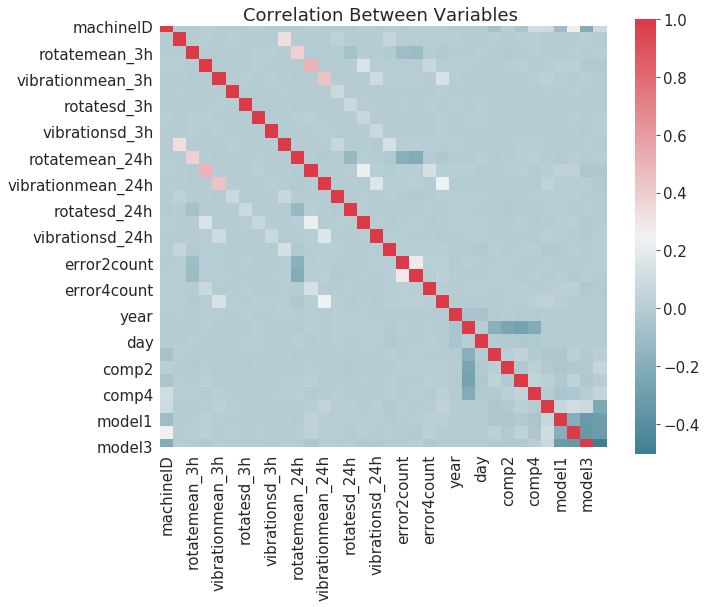

In [93]:
### Correlation Analysis
# It is necessary to eliminate the variables with high correlation (only one), consider> 70%.
f, ax = plt.subplots(figsize=(10, 8))
corr = labeled_features.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title("Correlation Between Variables ")
plt.show()

In [94]:
# We save to apply hyper-parameter optimization.
#labeled_features.to_pickle("final_datset.pickle")

In [95]:
# We establish the times corresponding to the records that will be used for training and tests.
import pandas as pd
threshold_dates = [
    pd.to_datetime("2015-09-30 01:00:00"), pd.to_datetime("2015-10-01 01:00:00")
]

In [96]:
test_results = []
models = []
total = len(threshold_dates)

In [97]:
# We make the partition of separate dates.
last_train_date = threshold_dates[0]
first_test_date = threshold_dates[1]

In [98]:
# Typically 20-30% of data is used.
ntraining = labeled_features.loc[labeled_features["datetime"] < last_train_date]
ntesting = labeled_features.loc[labeled_features["datetime"] > first_test_date]
print(f"{ntraining.shape[0]} records for training.")
print(f"{ntesting.shape[0]} records for testing.")
print(f"{ntesting.shape[0] / ntraining.shape[0] * 100:0.1f}% of the data will be used for testing.")

216733 records for training.
73809 records for testing.
34.1% of the data will be used for testing.


In [99]:
fails_train = ntraining[ntraining["failure"] != "none"].shape[0]
no_fails_train = ntraining[ntraining["failure"] == "none"].shape[0]
fails_test = ntesting[ntesting["failure"] != "none"].shape[0]
no_fails_test = ntesting[ntesting["failure"] == "none"].shape[0]

In [100]:
print(f"{fails_train / no_fails_train * 100:0.1f}% of the cases are training set failures.")
print(f"{fails_test / no_fails_test * 100:0.1f}% of the cases are failures in the test set.")

2.0% of the cases are training set failures.
1.9% of the cases are failures in the test set.


In [101]:

# We assign the corresponding values ​​to training and tests.
train_y = labeled_features.loc[labeled_features["datetime"] < last_train_date, "failure"]
train_X = labeled_features.loc[labeled_features["datetime"] < last_train_date].drop(["datetime",
                                                                                    "machineID",
                                                                                    "failure"], axis=1)
test_y = labeled_features.loc[labeled_features["datetime"] > first_test_date, "failure"]
test_X = labeled_features.loc[labeled_features["datetime"] > first_test_date].drop(["datetime",
                                                                                   "machineID",
                                                                                   "failure"], axis=1)

In [102]:
train_y
test_y

2175      none
2176      none
2177      none
2178      none
2179      none
          ... 
291337    none
291338    none
291339    none
291340    none
291341    none
Name: failure, Length: 73809, dtype: category
Categories (5, object): ['comp1', 'comp2', 'comp3', 'comp4', 'none']

In [103]:
train_X

,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,...,day,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
0,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,...,2,20.000,215.000,155.000,170.000,18,0,0,1,0
1,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,...,2,20.125,215.125,155.125,170.125,18,0,0,1,0
2,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,...,2,20.250,215.250,155.250,170.250,18,0,0,1,0
3,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,...,2,20.375,215.375,155.375,170.375,18,0,0,1,0
4,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,...,2,20.500,215.500,155.500,170.500,18,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290591,155.079380,450.187759,101.838938,44.109299,23.896443,26.392918,10.179211,7.432649,170.528530,444.326173,...,29,4.250,64.250,49.250,34.250,5,0,0,0,1
290592,185.390529,435.256907,92.831119,43.530138,18.810846,78.604196,10.683806,0.878059,169.717305,446.631597,...,29,4.375,64.375,49.375,34.375,5,0,0,0,1
290593,166.113912,444.157407,103.054512,38.293968,13.242216,34.509446,7.649707,3.353351,171.360297,444.384052,...,29,4.500,64.500,49.500,34.500,5,0,0,0,1
290594,157.015479,468.556698,106.294096,42.696208,13.348122,79.293067,7.683379,6.912312,169.644686,443.355974,...,29,4.625,64.625,49.625,34.625,5,0,0,0,1


In [104]:
# %%timeit
# Model training.
# model = GradientBoostingClassifier(random_state=42)
model = xgb(n_jobs=-1)
model.fit(train_X, train_y)

[09:57:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [105]:
from xgboost import XGBClassifier
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=None, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, nthread=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, tree_method=None, ...)

In [106]:
# We obtain results on the test set.
test_result = pd.DataFrame(labeled_features.loc[labeled_features["datetime"] > first_test_date])
test_result["predicted_failure"] = model.predict(test_X)
test_results.append(test_result)
models.append(model)

In [107]:
test_results

[        machineID            datetime  voltmean_3h  rotatemean_3h  \
 2175            1 2015-10-01 03:00:00   170.301017     449.036995   
 2176            1 2015-10-01 06:00:00   165.339972     435.660354   
 2177            1 2015-10-01 09:00:00   183.752875     463.058640   
 2178            1 2015-10-01 12:00:00   177.866822     506.692032   
 2179            1 2015-10-01 15:00:00   167.471524     425.963281   
 ...           ...                 ...          ...            ...   
 291337        100 2015-12-31 18:00:00   177.758754     458.391629   
 291338        100 2015-12-31 21:00:00   166.078945     424.431184   
 291339        100 2016-01-01 00:00:00   158.327984     504.056262   
 291340        100 2016-01-01 03:00:00   170.306956     438.653616   
 291341        100 2016-01-01 06:00:00   182.525427     435.932056   
 
         pressuremean_3h  vibrationmean_3h  voltsd_3h  rotatesd_3h  \
 2175          94.805205         40.816797  11.061667    58.425055   
 2176         103.

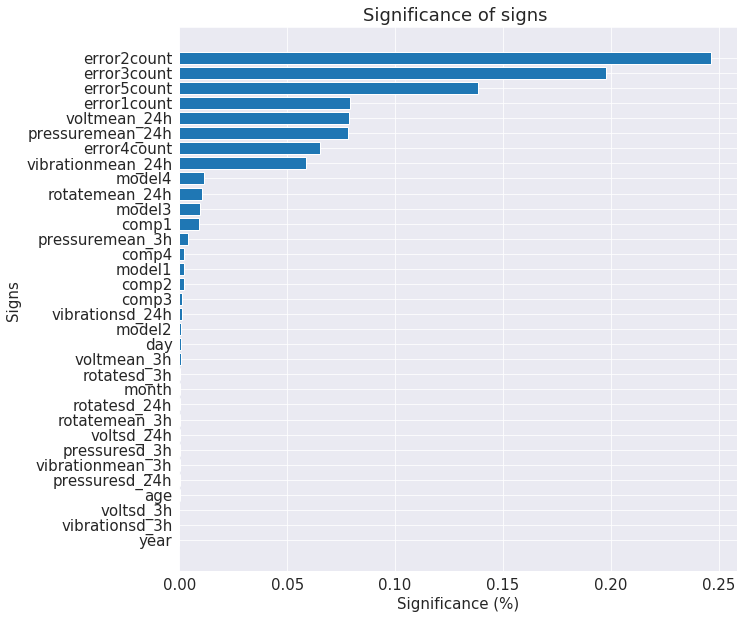

In [108]:
# Below, we plot the feature importances in the (first) trained model
plt.figure(figsize=(10, 10))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=False, key=lambda x: x[1]))
plt.yticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.barh(range(len(importances)), importances)
plt.ylabel("Signs ")
plt.xlabel("Significance (%)")
plt.title("Significance of signs ")
plt.show()

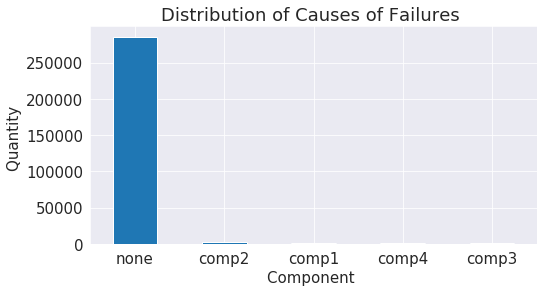

In [109]:
# There is an expected imbalance.
plt.figure(figsize=(8, 4))
labeled_features["failure"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribution of Causes of Failures ")
plt.xlabel("Component ")
plt.ylabel("Quantity ")
plt.show()

In [110]:
def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    #print("Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels")
    #print(cm)
    
    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(["accuracy", "precision", "recall", "F1"])
    
    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(["macro precision", "macro recall", "macro F1"])
    
    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(["average accuracy",
                          "micro-averaged precision/recall/F1"])
    
    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(["majority class accuracy", "majority class recall",
                          "majority class precision", "majority class F1"])
        
    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(["expected accuracy", "kappa"])
    

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(["random guess accuracy", "random guess precision",
                          "random guess recall", "random guess F1"])
    
    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(["random weighted guess accuracy",
                          "random weighted guess precision",
                          "random weighted guess recall",
                          "random weighted guess F1"])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df



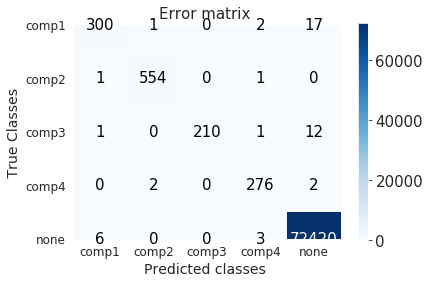

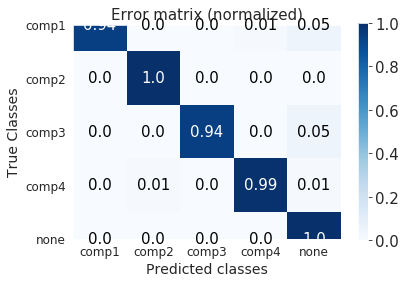

In [111]:
evaluation_results = []
test_result = test_results[0]
evaluation_result = Evaluate(actual = test_result["failure"],
                             predicted = test_result["predicted_failure"],
                             labels = ["none", "comp1", "comp2", "comp3", "comp4"])
skplt.metrics.plot_confusion_matrix(
    test_result["failure"],
    test_result["predicted_failure"],
    normalize=False,
    title=" Error matrix "
)
plt.ylabel(' True Classes ', fontsize=14)
plt.xlabel('Predicted classes ', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Error matrix ", fontsize=15)

skplt.metrics.plot_confusion_matrix(
    test_result["failure"],
    test_result["predicted_failure"],
    normalize=True,
)
plt.ylabel('True Classes', fontsize=14)
plt.xlabel('Predicted classes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Error matrix (normalized)", fontsize=15)

plt.show()



In [112]:
evaluation_results.append(evaluation_result)
evaluation_results[0]  # show full results for first split only

,none,comp1,comp2,comp3,comp4
accuracy,0.999336,0.999336,0.999336,0.999336,0.999336
precision,0.999572,0.974026,0.994614,1.000000,0.975265
recall,0.999876,0.937500,0.996403,0.937500,0.985714
F1,0.999724,0.955414,0.995508,0.967742,0.980462
macro precision,0.988695,0.988695,0.988695,0.988695,0.988695
macro recall,0.971399,0.971399,0.971399,0.971399,0.971399
macro F1,0.979770,0.979770,0.979770,0.979770,0.979770
average accuracy,0.999734,0.999734,0.999734,0.999734,0.999734
micro-averaged precision/recall/F1,0.999336,0.999336,0.999336,0.999336,0.999336
majority class accuracy,0.981303,0.000000,0.000000,0.000000,0.000000


In [113]:
evaluation_results[0].mean(axis=1)[0:4]

accuracy     0.999336
precision    0.988695
recall       0.971399
F1           0.979770
dtype: float64

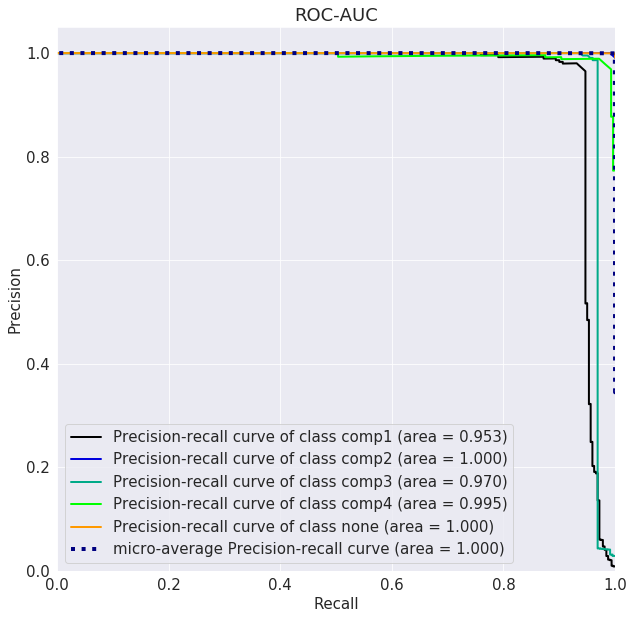

In [114]:
# For a binary classification problem, the ROC-AUC curve is generally used..
# For this multi-class case we will use precision vs sensitivity.
skplt.metrics.plot_precision_recall_curve(
    test_y,
    model.predict_proba(test_X),
    title="ROC-AUC",
    figsize=(10,10)
)
plt.show()

In [115]:
evaluation_results[0].loc["recall"].values

array([0.99987574, 0.9375    , 0.99640288, 0.9375    , 0.98571429])

In [116]:
# Recall becomes more important as the consequences of false negatives -true failures that 
#the model did not predict exceed the consequences of false positives, viz. false prediction of impending failure
# If the recall rates for all components as well as no failure are all above 90% 
# meaning the model was able to capture above 90% of the failures correctly.
recall_df = pd.DataFrame([evaluation_results[0].loc["recall"].values],
                         columns=["none", "comp1", "comp2", "comp3", "comp4"],
                         index=[" Component Sensitivity "])
recall_df.T

,Component Sensitivity
none,0.999876
comp1,0.937500
comp2,0.996403
comp3,0.937500
comp4,0.985714


In [117]:
###Individual Test Case

In [118]:
test_values = train_X.iloc[0].values
test_values

array([1.80133784e+02, 4.40608320e+02, 9.41379695e+01, 4.15515436e+01,
       2.13227348e+01, 4.87705120e+01, 2.13568373e+00, 1.00372081e+01,
       1.69733809e+02, 4.45179865e+02, 9.67971130e+01, 4.03851600e+01,
       1.12331203e+01, 4.87173948e+01, 1.00798802e+01, 5.85320856e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.01500000e+03, 1.00000000e+00, 2.00000000e+00,
       2.00000000e+01, 2.15000000e+02, 1.55000000e+02, 1.70000000e+02,
       1.80000000e+01, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00])

In [119]:
train_X

,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,...,day,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
0,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,...,2,20.000,215.000,155.000,170.000,18,0,0,1,0
1,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,...,2,20.125,215.125,155.125,170.125,18,0,0,1,0
2,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,...,2,20.250,215.250,155.250,170.250,18,0,0,1,0
3,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,...,2,20.375,215.375,155.375,170.375,18,0,0,1,0
4,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,...,2,20.500,215.500,155.500,170.500,18,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290591,155.079380,450.187759,101.838938,44.109299,23.896443,26.392918,10.179211,7.432649,170.528530,444.326173,...,29,4.250,64.250,49.250,34.250,5,0,0,0,1
290592,185.390529,435.256907,92.831119,43.530138,18.810846,78.604196,10.683806,0.878059,169.717305,446.631597,...,29,4.375,64.375,49.375,34.375,5,0,0,0,1
290593,166.113912,444.157407,103.054512,38.293968,13.242216,34.509446,7.649707,3.353351,171.360297,444.384052,...,29,4.500,64.500,49.500,34.500,5,0,0,0,1
290594,157.015479,468.556698,106.294096,42.696208,13.348122,79.293067,7.683379,6.912312,169.644686,443.355974,...,29,4.625,64.625,49.625,34.625,5,0,0,0,1


In [120]:
# XGBoost accepts only 2-dimensional arrays.
single_test = pd.DataFrame([test_values], columns=test_X.columns, index=[0])
single_test

,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,...,day,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
0,180.133784,440.60832,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,...,2.0,20.0,215.0,155.0,170.0,18.0,0.0,0.0,1.0,0.0


In [121]:
probas = model.predict_proba(single_test)
probas

array([[3.2965926e-07, 2.9228372e-07, 2.5161685e-07, 2.5470933e-07,
        9.9999893e-01]], dtype=float32)

In [122]:
prediction = model.predict(single_test)
prediction

array(['none'], dtype=object)

In [123]:
ordered_classes = np.unique(np.array(test_y))
ordered_classes

array(['comp1', 'comp2', 'comp3', 'comp4', 'none'], dtype=object)

In [124]:
gr_test = pd.DataFrame(test_X.values, columns=test_X.columns)
gr_test

,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,...,day,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
0,170.301017,449.036995,94.805205,40.816797,11.061667,58.425055,4.931305,2.428740,178.008406,453.336357,...,1.0,28.875,13.875,118.875,28.875,18.0,0.0,0.0,1.0,0.0
1,165.339972,435.660354,103.351320,31.892462,10.717864,26.009485,22.071933,6.020669,178.277009,452.064940,...,1.0,29.000,14.000,119.000,29.000,18.0,0.0,0.0,1.0,0.0
2,183.752875,463.058640,109.525083,41.945037,9.369264,43.646584,10.859804,9.395067,176.380067,444.022795,...,1.0,29.125,14.125,119.125,29.125,18.0,0.0,0.0,1.0,0.0
3,177.866822,506.692032,98.745260,39.861149,16.596090,38.086352,10.410456,5.418325,176.356632,457.097293,...,1.0,29.250,14.250,119.250,29.250,18.0,0.0,0.0,1.0,0.0
4,167.471524,425.963281,111.996389,39.396999,9.015089,63.342755,4.648154,6.365146,177.911567,453.677320,...,1.0,29.375,14.375,119.375,29.375,18.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73804,177.758754,458.391629,103.183160,46.846592,13.147011,75.100940,3.111700,3.576693,169.764418,454.478787,...,31.0,82.500,7.500,82.500,52.500,5.0,0.0,0.0,0.0,1.0
73805,166.078945,424.431184,98.344409,30.907459,29.351231,69.348245,16.940674,3.731256,171.547643,452.351565,...,31.0,82.625,7.625,82.625,52.625,5.0,0.0,0.0,0.0,1.0
73806,158.327984,504.056262,108.055441,40.109705,9.605817,78.036116,9.154932,3.379639,168.806645,459.502212,...,1.0,82.750,7.750,82.750,52.750,5.0,0.0,0.0,0.0,1.0
73807,170.306956,438.653616,102.346227,47.481232,8.457322,43.021553,0.785721,3.198928,169.011763,465.923073,...,1.0,82.875,7.875,82.875,52.875,5.0,0.0,0.0,0.0,1.0


In [125]:
probas = model.predict_proba(gr_test)
prediction = model.predict(gr_test)
prediction

array(['none', 'none', 'none', ..., 'none', 'none', 'none'], dtype=object)

In [126]:
ordered_classes = np.unique(np.array(test_y))
ordered_classes

array(['comp1', 'comp2', 'comp3', 'comp4', 'none'], dtype=object)

In [127]:
results = pd.DataFrame(probas,
                       columns=ordered_classes)
results

,comp1,comp2,comp3,comp4,none
0,1.689411e-07,2.051377e-07,1.904208e-07,2.070896e-07,0.999999
1,1.608473e-07,2.051377e-07,1.847103e-07,2.070896e-07,0.999999
2,5.910833e-07,5.508514e-07,4.888701e-07,4.800376e-07,0.999998
3,5.451738e-07,5.191756e-07,4.607587e-07,4.524342e-07,0.999998
4,7.000456e-07,8.259802e-07,7.110575e-07,8.338386e-07,0.999997
...,...,...,...,...,...
73804,5.218247e-07,2.470951e-07,2.192923e-07,3.352864e-07,0.999999
73805,2.414546e-07,1.739470e-07,1.497451e-07,1.756022e-07,0.999999
73806,2.436065e-07,1.754977e-07,1.557507e-07,1.771674e-07,0.999999
73807,2.502483e-07,1.754977e-07,1.510798e-07,2.867303e-07,0.999999


In [128]:
print(f" Prediction: {prediction}")
results

 Prediction: ['none' 'none' 'none' ... 'none' 'none' 'none']


,comp1,comp2,comp3,comp4,none
0,1.689411e-07,2.051377e-07,1.904208e-07,2.070896e-07,0.999999
1,1.608473e-07,2.051377e-07,1.847103e-07,2.070896e-07,0.999999
2,5.910833e-07,5.508514e-07,4.888701e-07,4.800376e-07,0.999998
3,5.451738e-07,5.191756e-07,4.607587e-07,4.524342e-07,0.999998
4,7.000456e-07,8.259802e-07,7.110575e-07,8.338386e-07,0.999997
...,...,...,...,...,...
73804,5.218247e-07,2.470951e-07,2.192923e-07,3.352864e-07,0.999999
73805,2.414546e-07,1.739470e-07,1.497451e-07,1.756022e-07,0.999999
73806,2.436065e-07,1.754977e-07,1.557507e-07,1.771674e-07,0.999999
73807,2.502483e-07,1.754977e-07,1.510798e-07,2.867303e-07,0.999999


In [129]:
np.unique(prediction, return_counts = True)

(array(['comp1', 'comp2', 'comp3', 'comp4', 'none'], dtype=object),
 array([  308,   557,   210,   283, 72451]))

In [130]:
for i, j in zip(prediction, range(len(prediction))):
    if i != 'none':
        print(prediction[j], 1-results.none[j])

comp2 0.9999658084088878
comp2 0.999974804914018
comp2 0.999979908208843
comp2 0.9999776998374728
comp2 0.9999796528918523
comp2 0.9999241570258164
comp2 0.9999696697468607
comp2 0.9995913332677446
comp4 0.9999440013634739
comp4 0.9997966460941825
comp4 0.999896611639997
comp4 0.9999200843667495
comp4 0.9998987805302022
comp4 0.9999606678247801
comp4 0.9999606678247801
comp4 0.9998911819639034
comp2 0.9999577182461508
comp2 0.9999654447783541
comp2 0.9998860217601759
comp2 0.9999468894675374
comp2 0.9999604839067615
comp2 0.9999720744344813
comp2 0.9999794046489114
comp2 0.9998706618207507
comp2 0.9999816025283508
comp2 0.9999715910744271
comp2 0.9999783776056574
comp2 0.9999784823630762
comp2 0.9999832083831279
comp2 0.9999840485124878
comp2 0.9999812617024872
comp2 0.9998383534402819
comp2 0.9999787562810525
comp2 0.9999819721797394
comp2 0.999979639564117
comp2 0.9999827845276741
comp2 0.9999823703637958
comp2 0.9999818009619048
comp2 0.9999818928372406
comp2 0.9998002926149638
comp

comp2 0.9999123762681847
comp2 0.9999715985850344
comp2 0.9999408625699289
comp2 0.9999670895958843
comp2 0.9998876087338431
comp4 0.9999349752324633
comp4 0.99995672067962
comp4 0.9999593400243612
comp4 0.9999436242651427
comp4 0.9998613413918065
comp4 0.9999647040167474
comp4 0.999972720790538
comp4 0.9998476896435022
comp2 0.999979261048793
comp2 0.9999804846193001
comp2 0.9999798883327458
comp2 0.9999803358568897
comp2 0.9999722604297858
comp2 0.9999686882401875
comp2 0.9999751576524432
comp2 0.9998936523479642
comp3 0.9997711879550479
comp3 0.9998628358007409
comp3 0.9997964469657745
comp3 0.9998728954815306
comp3 0.9998349898523884
comp3 0.9998733828106197
comp3 0.9994028607034124
comp3 0.9978359800297767
comp2 0.9998963683829061
comp2 0.9999679189277231
comp2 0.9999559453499387
comp2 0.9999678099811717
comp2 0.9999713212691859
comp2 0.9999705612317484
comp2 0.999972921978042
comp2 0.9998769888334209
comp4 0.9999639397392457
comp4 0.99943471851293
comp4 0.9999696530267101
comp4 0

In [131]:
test_X.head()

,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,...,day,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
2175,170.301017,449.036995,94.805205,40.816797,11.061667,58.425055,4.931305,2.428740,178.008406,453.336357,...,1,28.875,13.875,118.875,28.875,18,0,0,1,0
2176,165.339972,435.660354,103.351320,31.892462,10.717864,26.009485,22.071933,6.020669,178.277009,452.064940,...,1,29.000,14.000,119.000,29.000,18,0,0,1,0
2177,183.752875,463.058640,109.525083,41.945037,9.369264,43.646584,10.859804,9.395067,176.380067,444.022795,...,1,29.125,14.125,119.125,29.125,18,0,0,1,0
2178,177.866822,506.692032,98.745260,39.861149,16.596090,38.086352,10.410456,5.418325,176.356632,457.097293,...,1,29.250,14.250,119.250,29.250,18,0,0,1,0
2179,167.471524,425.963281,111.996389,39.396999,9.015089,63.342755,4.648154,6.365146,177.911567,453.677320,...,1,29.375,14.375,119.375,29.375,18,0,0,1,0


In [132]:
train_X.head(20)

,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,...,day,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
0,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,...,2,20.000,215.000,155.000,170.000,18,0,0,1,0
1,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,...,2,20.125,215.125,155.125,170.125,18,0,0,1,0
2,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,...,2,20.250,215.250,155.250,170.250,18,0,0,1,0
3,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,...,2,20.375,215.375,155.375,170.375,18,0,0,1,0
4,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,...,2,20.500,215.500,155.500,170.500,18,0,0,1,0
5,163.278466,446.493166,104.387585,38.068116,21.580492,41.380958,20.725597,6.932127,170.556674,452.267095,...,2,20.625,215.625,155.625,170.625,18,0,0,1,0
6,172.191198,434.214692,93.747282,39.716482,16.369836,14.636041,18.817326,3.426997,168.460525,451.031783,...,3,20.750,215.750,155.750,170.750,18,0,0,1,0
7,175.210027,504.845430,108.512153,37.763933,5.991921,16.062702,6.382608,3.449468,169.772951,447.502464,...,3,20.875,215.875,155.875,170.875,18,0,0,1,0
8,181.690108,472.783187,93.395164,38.621099,11.514450,47.880443,2.177029,7.670520,170.900562,453.864597,...,3,21.000,216.000,156.000,171.000,18,0,0,1,0
9,172.382935,505.141261,98.524373,49.965572,7.065150,56.849540,5.230039,2.687565,169.533156,454.785072,...,3,21.125,216.125,156.125,171.125,18,0,0,1,0


In [133]:
train_y.head(100)

0     none
1     none
2     none
3     none
4     none
      ... 
95    none
96    none
97    none
98    none
99    none
Name: failure, Length: 100, dtype: category
Categories (5, object): ['comp1', 'comp2', 'comp3', 'comp4', 'none']

In [134]:
labeled_features.loc[labeled_features['failure'] != 'none'].sample(5)

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,comp1,comp2,comp3,comp4,age,failure,model1,model2,model3,model4
42491,15,2015-08-02 18:00:00,193.128806,494.237168,96.081554,42.082432,16.419755,32.935961,8.185856,5.460195,...,44.500,44.500,74.500,194.500,14,comp1,0,0,1,0
187653,65,2015-05-31 06:00:00,197.416148,426.355631,101.993090,44.178851,20.058141,16.883697,14.949862,7.641738,...,0.000,15.000,60.000,244.000,15,comp1,0,0,1,0
210605,73,2015-04-16 21:00:00,179.559789,470.951540,104.148397,51.354805,19.458235,39.099714,7.382626,7.247078,...,14.625,139.625,89.625,59.625,20,comp4,0,1,0,0
243272,84,2015-07-03 15:00:00,191.843377,472.452821,108.915997,41.558136,15.936093,69.495428,16.865267,8.834661,...,44.375,89.375,14.375,14.375,9,comp1,0,0,1,0
145019,50,2015-10-11 09:00:00,171.160100,353.973438,107.012322,35.831937,14.021168,86.527119,10.750409,6.058367,...,14.125,29.125,44.125,104.125,4,comp2,0,0,0,1


In [135]:
test_value_2 = train_X.iloc[41].values
test_value_2


array([1.81639071e+02, 4.36475291e+02, 9.68754710e+01, 3.87184835e+01,
       8.32522606e+00, 1.58161635e+01, 1.15409292e+01, 9.24042479e+00,
       1.71625196e+02, 4.41774893e+02, 1.01000854e+02, 4.19175765e+01,
       1.77770045e+01, 4.41610765e+01, 1.00885421e+01, 3.98590447e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.01500000e+03, 1.00000000e+00, 7.00000000e+00,
       2.12500000e+00, 2.20125000e+02, 1.60125000e+02, 2.12500000e+00,
       1.80000000e+01, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00])

In [136]:
single_test_2 = pd.DataFrame([test_value_2], columns=test_X.columns, index=[0])
single_test_2


,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,...,day,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
0,181.639071,436.475291,96.875471,38.718484,8.325226,15.816164,11.540929,9.240425,171.625196,441.774893,...,7.0,2.125,220.125,160.125,2.125,18.0,0.0,0.0,1.0,0.0


In [137]:
prediction = model.predict(single_test_2)
prediction

array(['none'], dtype=object)

In [138]:
test_value_3 = train_X.iloc[44].values
test_value_3

array([1.65781638e+02, 4.69226058e+02, 1.01850990e+02, 4.31738905e+01,
       1.35465223e+01, 3.30291155e+01, 8.85356156e+00, 5.15477144e+00,
       1.70577937e+02, 4.48122930e+02, 9.97212725e+01, 4.13796030e+01,
       1.38954321e+01, 3.97959256e+01, 1.14673484e+01, 5.38867778e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.01500000e+03, 1.00000000e+00, 7.00000000e+00,
       2.50000000e+00, 2.20500000e+02, 1.60500000e+02, 2.50000000e+00,
       1.80000000e+01, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00])

In [139]:
single_test_3 = pd.DataFrame([test_value_3], columns=test_X.columns, index=[0])
single_test_3

,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,...,day,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
0,165.781638,469.226058,101.85099,43.17389,13.546522,33.029115,8.853562,5.154771,170.577937,448.12293,...,7.0,2.5,220.5,160.5,2.5,18.0,0.0,0.0,1.0,0.0


In [140]:
prediction = model.predict(single_test_3)
prediction

array(['none'], dtype=object)

In [141]:
test_value_3 = train_X.iloc[45].values
single_test_3 = pd.DataFrame([test_value_3], columns=test_X.columns, index=[0])
prediction = model.predict(single_test_3)
prediction


array(['none'], dtype=object)

In [142]:

test_value_3 = train_X.iloc[236920].values
single_test_3 = pd.DataFrame([test_value_3], columns=test_X.columns, index=[0])
prediction = model.predict(single_test_3)
prediction


IndexError: single positional indexer is out-of-bounds

In [ ]:
# Rand_df = pd.DataFrame({'Actual': test_y, 'Predicted': prediction})
# Rand_df


In [ ]:
# # Rand_df.loc[Rand_df['Predicted'] != 'none']
# Rand_df[((Rand_df['Actual'] ) != (Rand_df['Predicted']))]

In [ ]:
#####Different Alg
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
clf = RandomForestClassifier()
# clf = MultinomialNB()
# clf = LogisticRegression()
# clf = svm.SVC()
# clf = KNeighborsClassifier()
# unite the features and classifier together
pipe = Pipeline([
                 ('clf',clf)
                 ])



In [ ]:
# # pipe = Pipeline([('scaler', StandardScaler()),  ('nB',MultinomialNB()), ('rf',RandomForestClassifier()),('KNN',KNeighborsClassifier())])
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import VarianceThreshold # Feature selector
# pipe = Pipeline([
# ('scaler', StandardScaler()),
# ('selector', VarianceThreshold()),
# ('classifier', KNeighborsClassifier())
# ])

In [ ]:
pipe.fit(train_X, train_y)
preds = pipe.predict(test_X)

In [ ]:
print('Training set score: ' + str(pipe.score(train_X, train_y)))
print('Test set score: ' + str(pipe.score(test_X, test_y)))


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y,preds))

In [ ]:
Rand_df = pd.DataFrame({'Actual': test_y, 'Predicted': preds})
Rand_df


In [ ]:
Rand_df[((Rand_df['Actual'] ) != (Rand_df['Predicted']))]

In [ ]:
pipe

In [ ]:
preds

In [ ]:
#Create a pipeline consisting of a linear SVM, a simple Decision Tree and a simple Random Forest Classifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import tree
## KEEP IT FOR NOW
# Construct some pipelines
pipe_svm = Pipeline([('pca', PCA(n_components=27)),
        ('clf', svm.SVC(random_state=123))])
        
pipe_tree = Pipeline([('pca', PCA(n_components=27)),
        ('clf', tree.DecisionTreeClassifier(random_state=123))])
pipe_rf = Pipeline([('pca', PCA(n_components=27)),
        ('clf', RandomForestClassifier(random_state=123))])
# List of pipelines, List of pipeline names
pipelines = [pipe_svm, pipe_tree, pipe_rf]
pipeline_names = ['Support Vector Machine','Decision Tree','Random Forest']
# Loop to fit each of the three pipelines


In [ ]:
from sklearn.tree import DecisionTreeClassifier
for pipe in pipelines:
    # print(pipe)
    pipe.fit(train_X, train_y)
    preds = pipe.predict(test_X)
# Compare accuracies
for index, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(test_X, test_y)))
    print('Training set score: ' + str(pipe.score(train_X, train_y)))
    print('Test set score: ' + str(pipe.score(test_X, test_y))) 
    print(classification_report(test_y,preds))


In [ ]:
##########

In [ ]:
######ENSEMBLE MODELS

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [ ]:
rf_clf.fit(train_X, train_y)

In [ ]:
preds_ens = rf_clf.predict(test_X)

In [ ]:
Ensemble_df = pd.DataFrame({'Actual': test_y, 'Predicted': preds_ens})
Ensemble_df

In [ ]:
Ensemble_df[((Ensemble_df['Actual'] ) != (Ensemble_df['Predicted']))]

In [ ]:
print('Training set score: ' + str(rf_clf.score(train_X, train_y)))
print('Test set score: ' + str(rf_clf.score(test_X, test_y)))
print(classification_report(test_y,preds_ens))

In [ ]:
#Bagging
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(base_estimator=rf_clf, n_estimators=1000,
                            bootstrap=True, n_jobs=-1,
                            random_state=42)

In [ ]:
bag_clf.fit(train_X, train_y)

In [ ]:
bag_preds = bag_clf.predict(test_X)

In [ ]:
print('Training set score: ' + str(bag_clf.score(train_X, train_y)))
print('Test set score: ' + str(bag_clf.score(test_X, test_y)))
print(classification_report(test_y,bag_preds))

In [ ]:
preds_bag = bag_clf.predict(test_X)
Bag_df = pd.DataFrame({'Actual': test_y, 'Predicted': preds_bag})
Bag_df

In [ ]:
Bag_df[((Bag_df['Actual'] ) != (Bag_df['Predicted']))]

In [ ]:
# #Gradient Tree Boosting
# from sklearn.ensemble import GradientBoostingClassifier
# m = GradientBoostingClassifier(n_estimators=10)

# m.fit(train_X, train_y)
# Tree_ens = m.predict(test_X)
# T_ens = pd.DataFrame({'Actual': test_y, 'Predicted': Tree_ens})
# T_ens

In [ ]:
# T_ens[((T_ens['Actual'] ) != (T_ens['Predicted']))]

In [ ]:
#Voting Classifier
#The idea behind the voting classifier implementation is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. 
#Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.
from sklearn.ensemble import VotingClassifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


m = VotingClassifier(
    estimators=[('lr', LogisticRegression()), 
                ('rf', RandomForestClassifier()), 
                ('gnb', GaussianNB())], 
    voting='hard')

In [ ]:
m.fit(train_X, train_y)

In [ ]:
preds_voting = m.predict(test_X)

In [ ]:


print('Training set score: ' + str(m.score(train_X, train_y)))
print('Test set score: ' + str(m.score(test_X, test_y)))
print(classification_report(test_y,preds_voting))

In [ ]:
Voting_ens = m.predict(test_X)
Voting_e = pd.DataFrame({'Actual': test_y, 'Predicted': Voting_ens})
Voting_e

In [ ]:
Voting_e[((Voting_e['Actual'] ) != (Voting_e['Predicted']))]

In [ ]:
#AdaBoosting
from sklearn.tree import DecisionTreeClassifier
# forest = RandomForestClassifier()
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))


In [ ]:
ada.fit(train_X, train_y)

In [ ]:
preds_ada = ada.predict(test_X)

In [ ]:
from sklearn.metrics import classification_report
print('Training set score: ' + str(ada.score(train_X, train_y)))
print('Test set score: ' + str(ada.score(test_X, test_y)))
print(classification_report(test_y,preds_ada))

In [ ]:
AdaBoost_ens = ada.predict(test_X)
Ada_ens = pd.DataFrame({'Actual': test_y, 'Predicted': AdaBoost_ens})
Ada_ens

In [ ]:
Ada_ens[((Ada_ens['Actual'] ) != (Ada_ens['Predicted']))]

In [ ]:
#######################

In [ ]:
##Stacking##
from sklearn.ensemble import RandomForestClassifier
# forest = RandomForestClassifier()
# ada = AdaBoostClassifier(base_estimator=forest, n_estimators=100,
#                          learning_rate=0.5, random_state=42)
# bag_clf = BaggingClassifier(base_estimator=ada, n_estimators=50,
#                             max_samples=1.0, max_features=1.0, bootstrap=True,
#                             bootstrap_features=False, n_jobs=-1,
#                             random_state=42)
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
bag_clf = BaggingClassifier(base_estimator=ada)

In [ ]:
bag_clf.fit(train_X, train_y)

In [ ]:
preds_stack = bag_clf.predict(test_X)

In [ ]:

print('Training set score: ' + str(bag_clf.score(train_X, train_y)))
print('Test set score: ' + str(bag_clf.score(test_X, test_y)))
print(classification_report(test_y,preds_stack))

In [ ]:
a

In [ ]:
#shap
model

In [ ]:
# !pip install shap
import shap
X_frame = labeled_features.drop(["datetime", "machineID","failure"], axis=1)
# X_frame = pd.DataFrame(data=X, columns=X.design_info.column_names)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_frame)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:,:-1], X_frame)

In [ ]:
# See how every feaure contributes to the model output
shap.summary_plot(shap_values, X_frame)

In [ ]:
shap_values

In [ ]:
shap_values = explainer(X_frame[:100])
shap.plots.bar(shap_values)

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.waterfall_plot(explainer.base_values[0], values[0], X[0])

In [ ]:
shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0])

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0])